# Raptor

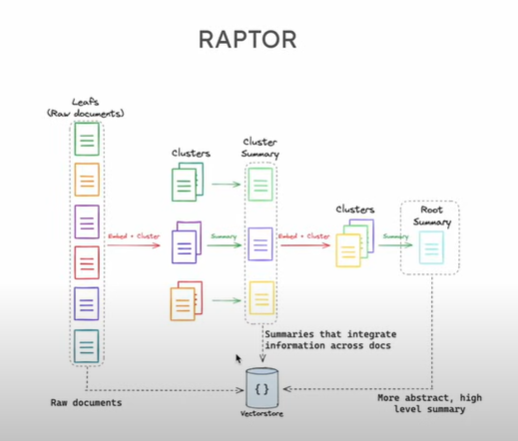

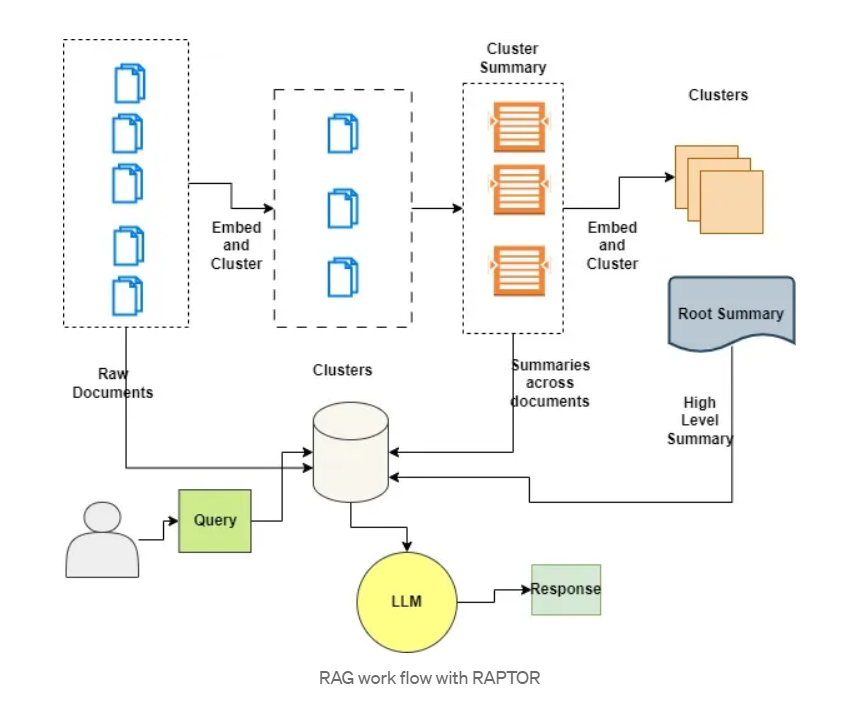

RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval

The RAPTOR paper presents an interesting approaching for indexing and retrieval of documents:

The leafs are a set of starting documents
Leafs are embedded and clustered
Clusters are then summarized into higher level (more abstract) consolidations of information across similar documents
This process is done recursivly, resulting in a "tree" going from raw docs (leafs) to more abstract summaries.

We can applying this at varying scales; leafs can be:

Text chunks from a single doc (as shown in the paper)
Full docs (as we show below)
With longer context LLMs, it's possible to perform this over full documents.

### Docs
Let's apply this to LangChain's LCEL documentation.

In this case, each doc is a unique web page of the LCEL docs.

The context varies from < 2k tokens on up to > 10k tokens.

### Models
We can test various models, including the new Claude3 family.

Be sure to set the relevant API keys:

* ANTHROPIC_API_KEY
* OPENAI_API_KEY

#### Tree Constrution

The clustering approach in tree construction includes a few interesting ideas.

#### GMM (Gaussian Mixture Model)

* Model the distribution of data points across different clusters
* Optimal number of clusters by evaluating the model's Bayesian Information Criterion (BIC)
 
#### UMAP (Uniform Manifold Approximation and Projection)

* Supports clustering
* Reduces the dimensionality of high-dimensional data
* UMAP helps to highlight the natural grouping of data points based on their similarities
  
#### Local and Global Clustering

* Used to analyze data at different scales
* Both fine-grained and broader patterns within the data are captured effectively
  
#### Thresholding

* Apply in the context of GMM to determine cluster membership
* Based on the probability distribution (assignment of data points to ≥ 1 cluster)


## Rag From Scratch: Indexing

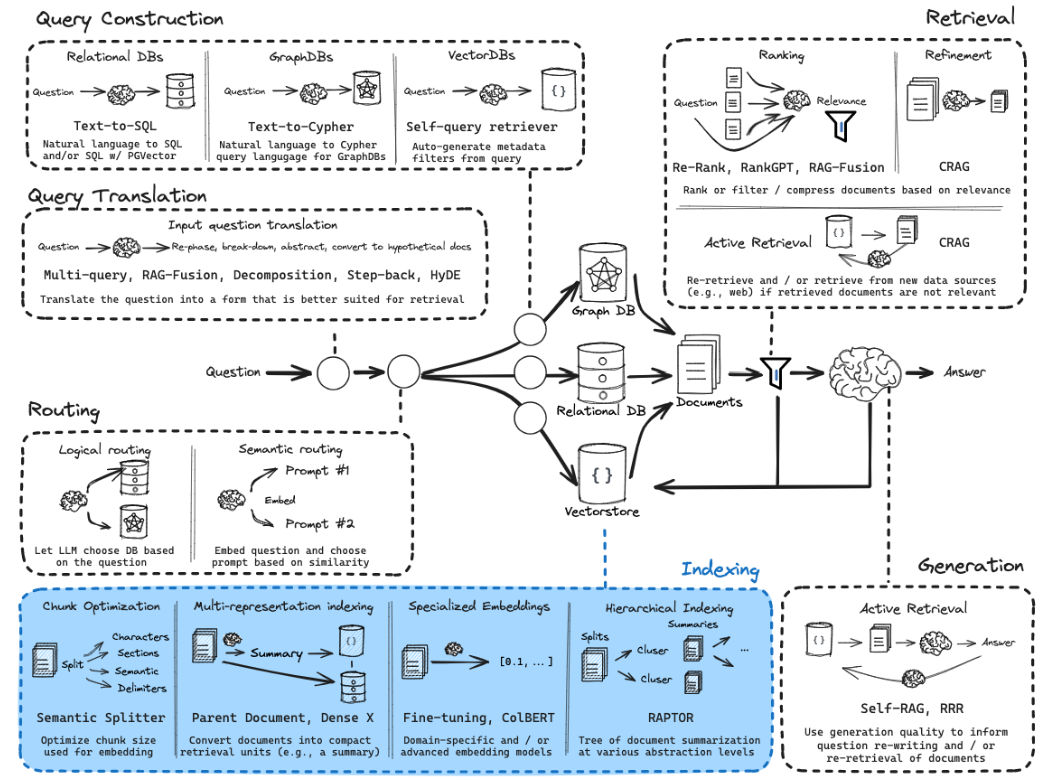

## Enviornment
(1) Packages

In [10]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain youtube-transcript-api pytube

(2) LangSmith

https://docs.smith.langchain.com/

In [11]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = ""

(3) API Keys

In [12]:
os.environ['OPENAI_API_KEY'] = ""

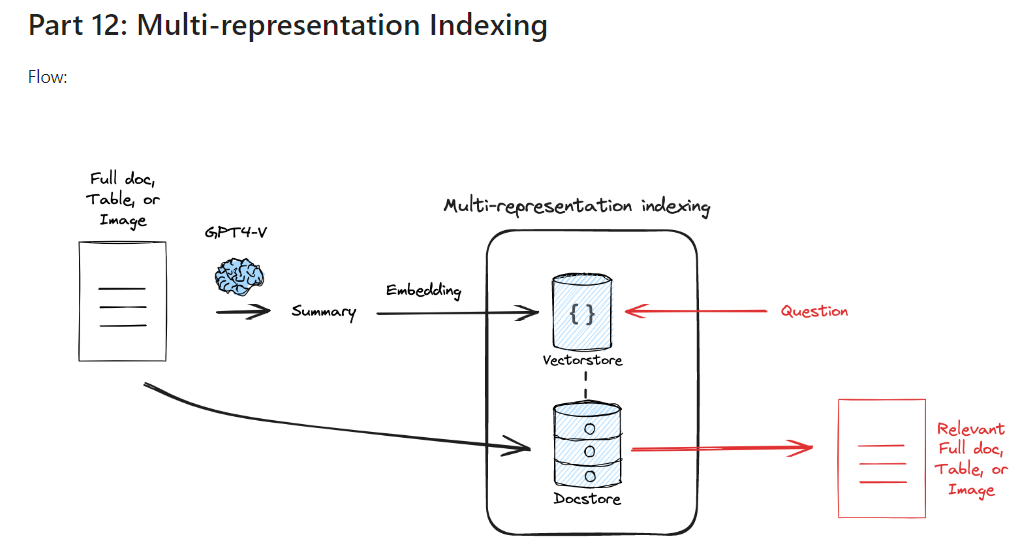

In [13]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

loader = WebBaseLoader("https://lilianweng.github.io/posts/2024-02-05-human-data-quality/")
docs.extend(loader.load())

In [14]:
import uuid

from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following document:\n\n{doc}")
    | ChatOpenAI(model="gpt-3.5-turbo",max_retries=0)
    | StrOutputParser()
)

summaries = chain.batch(docs, {"max_concurrency": 5})

In [15]:
from langchain.storage import InMemoryByteStore
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries",
                     embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryByteStore()
id_key = "doc_id"

# The retriever
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in docs]

# Docs linked to summaries
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

# Add
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, docs)))

In [16]:
query = "Memory in agents"
sub_docs = vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(page_content='The document discusses building autonomous agents powered by Large Language Models (LLMs). It covers key components like planning, memory, and tool use, along with case studies and proof-of-concept examples. Challenges in context length, planning, and natural language interface reliability are highlighted. The potential of LLMs extends beyond generating text to becoming problem solvers. The document provides a comprehensive overview of using LLMs in autonomous agent systems.', metadata={'doc_id': '54f9cfd4-7934-403d-996b-614d94b29cdd'})

In [17]:
retrieved_docs = retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content[0:500]

C:\Users\sonya\AppData\Local\Programs\Python\Python311\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
Number of requested results 4 is greater than number of elements in index 2, updating n_results = 2


"\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n"

# ColBERT

ColBERT is a kind of fine tuning Embedding Technique. 

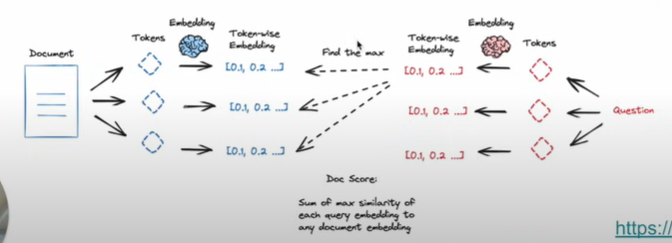



Documents are divided into Tokens before embedding.
Question also divided into Tokens first and then embedding in to vector. Taking the first token vector and compare to every vector in documents and compute the maximun match, then takes the second question token and find the max matched and storing etc. 
And the final score will be the sum of maximum similarities between every question token and any document token. 

ColBERT is a new way of scoring passage relevance using a BERT language model that substantially solves the problems with DPR.

Instead of traditional, single-vector-based DPR that turns passages into a single “embedding” vector, ColBERT generates a contextually influenced vector for each token in the passages. ColBERT similarly generates vectors for each token in the query.

In [18]:
! pip install -U ragatouille

     ---------------------------------------- 0.0/86.7 kB ? eta -:--:--
     ------------------------------------- -- 81.9/86.7 kB 2.3 MB/s eta 0:00:01
     ---------------------------------------- 86.7/86.7 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached faiss_cpu-1.8.0-cp311-cp311-win_amd64.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/138.0 kB ? eta -:--:--
     ----------------- --------------------- 61.4/138.0 kB 3.4 MB/s eta 0:00:01
     ------------------------------------ - 133.1/138.0 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 138.0/138.0 kB 1.4 MB/s eta 0:00:00
  Using cached PyYAML-6.0.1-cp311-cp311-win_amd64.whl.metadata (2.1 kB)
  Using cached nest_asyncio-1.6.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached pypdf-4.2.0-py3-none-any.whl.metadata (7.4 kB)
   

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.5.4 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
tensorflow-intel 2.13.0 requires numpy<=1.24.3,>=1.22, but you have numpy 1.26.4 which is incompatible.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.10.0 which is incompatible.


   ------------------ --------------------- 72.4/159.8 MB 2.0 MB/s eta 0:00:44
   ------------------ --------------------- 72.5/159.8 MB 2.0 MB/s eta 0:00:44
   ------------------ --------------------- 72.6/159.8 MB 2.0 MB/s eta 0:00:44
   ------------------ --------------------- 72.7/159.8 MB 2.0 MB/s eta 0:00:43
   ------------------ --------------------- 72.8/159.8 MB 2.1 MB/s eta 0:00:43
   ------------------ --------------------- 73.0/159.8 MB 2.1 MB/s eta 0:00:42
   ------------------ --------------------- 73.1/159.8 MB 2.1 MB/s eta 0:00:42
   ------------------ --------------------- 73.3/159.8 MB 2.1 MB/s eta 0:00:41
   ------------------ --------------------- 73.4/159.8 MB 2.1 MB/s eta 0:00:41
   ------------------ --------------------- 73.5/159.8 MB 2.1 MB/s eta 0:00:41
   ------------------ --------------------- 73.6/159.8 MB 2.1 MB/s eta 0:00:41
   ------------------ --------------------- 73.7/159.8 MB 2.1 MB/s eta 0:00:41
   ------------------ --------------------- 73.8/159

In [20]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

[May 14, 21:00:20] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


ImportError: DLL load failed while importing segmented_maxsim_cpp: The specified module could not be found.